In [2]:
import mlrose_hiive as mlrose
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import time

In [4]:
%config Completer.use_jedi = False

In [5]:
df = pd.read_csv("data/cancer/breast-cancer.csv", index_col="id")

In [6]:
df = df.drop(columns='Unnamed: 32')

In [7]:
diagnosis_map = {'B':0, 'M':1}
df['diagnosis'] = df['diagnosis'].map(diagnosis_map)

In [8]:
df.shape

(569, 31)

### Split data

In [9]:
x = df.drop(columns=['diagnosis'])
y = df['diagnosis']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=52)

print(f"train set size: {x_train.shape}")
print(f"test set size: {x_test.shape}")

train set size: (398, 30)
test set size: (171, 30)


### Scale

In [10]:
mm_scaler = MinMaxScaler()

x_train_mm = mm_scaler.fit_transform(x_train)
x_test_mm = mm_scaler.fit_transform(x_test)

print(np.min(x_train_mm))
print(np.max(x_train_mm))

0.0
1.0000000000000002


### Gradient Descent

In [14]:
def run_gd(X, y, epoch_range):
    # epoch, train score, train time
    data = []
    
    for epoch in epoch_range:
        if str(type(epoch)) == str(np.int64):
            epoch = int(epoch)

        nn_model = mlrose.NeuralNetwork(
            hidden_nodes=[12, 12],
            activation='relu',
            algorithm='gradient_descent',
            max_iters=epoch,
            bias=True,
            is_classifier=True,
            learning_rate=0.006,
            early_stopping=True,
            clip_max=1,
            max_attempts=100,
            random_state=52
        )
        ts = time.time()
        
        nn_model.fit(X, y)
    
        te = time.time()
        
        train_score= nn_model.score(X, y)
        
        row = [epoch, train_score, (te-ts)]
        data.append(row)
        
    df = pd.DataFrame(data, columns=['Epoch', 'Train_Score', 'Train_Time'])
    return df
    

In [15]:
epoch_range = 2 ** np.arange(10)

gd = run_gd(x_train_mm, y_train, epoch_range=epoch_range)

In [16]:
gd

,Epoch,Train_Score,Train_Time
0,1,0.517588,0.027468
1,2,0.517588,0.010797
2,4,0.530151,0.029498
3,8,0.633166,0.062727
4,16,0.731156,0.058222
5,32,0.869347,0.083027
6,64,0.899497,0.188797
7,128,0.932161,0.434459
8,256,0.942211,0.934598
9,512,0.924623,1.833495


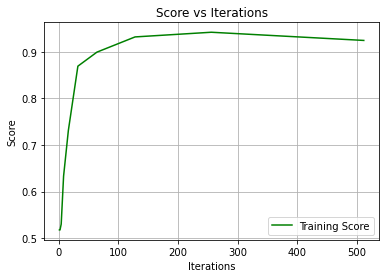

In [38]:
plt.title("Score vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Score") 

plt.plot(gd["Epoch"], gd["Train_Score"], label="Training Score", color ="green")

plt.legend()
plt.grid()
plt.savefig('images/nn/1_gd.png')
plt.show()

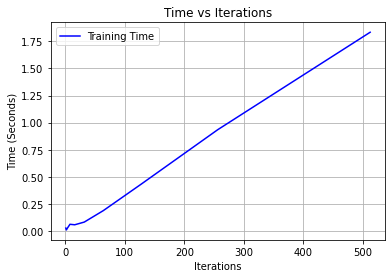

In [39]:
plt.title("Time vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Time (Seconds)") 

plt.plot(gd["Epoch"], gd["Train_Time"], label="Training Time", color ="blue")

plt.legend()
plt.grid()
plt.savefig('images/nn/2_gd.png')
plt.show()

### RHC Algo (Random Hill Climb )

In [40]:
def run_rhc(X,y, epoch_range):
    # epoch, train score, train time
    data = []
    
    for epoch in epoch_range:
        if str(type(epoch)) == str(np.int64):
            epoch = int(epoch)
        
        nn_model = mlrose.NeuralNetwork(
            hidden_nodes=[12, 12],
            activation='relu',
            algorithm='random_hill_climb',
            max_iters=epoch,
            bias=True,
            is_classifier=True,
            learning_rate=0.006,
            early_stopping=True,
            clip_max=1,
            max_attempts=100,
            random_state=52
        )
        ts = time.time()
        
        nn_model.fit(X, y)
    
        te = time.time()
        
        train_score= nn_model.score(X, y)
        
        row = [epoch, train_score, (te-ts)]
        data.append(row)
        
    df = pd.DataFrame(data, columns=['Epoch', 'Train_Score', 'Train_Time'])
    return df

In [30]:
epoch_range = 2 ** np.arange(15)

rhc = run_rhc(x_train_mm, y_train, epoch_range=epoch_range)

In [31]:
rhc

,Epoch,Train_Score,Train_Time
0,1,0.517588,0.011124
1,2,0.517588,0.009556
2,4,0.517588,0.017515
3,8,0.517588,0.033704
4,16,0.517588,0.037843
5,32,0.517588,0.054964
6,64,0.517588,0.102669
7,128,0.525126,0.201135
8,256,0.537688,0.406812
9,512,0.562814,1.090807


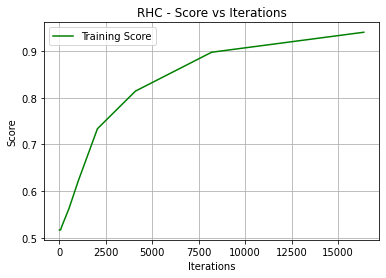

In [41]:
plt.title("RHC - Score vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Score") 

plt.plot(rhc["Epoch"], rhc["Train_Score"], label="Training Score", color ="green")

plt.legend()
plt.grid()
plt.savefig('images/nn/2_sa.png')
plt.show()

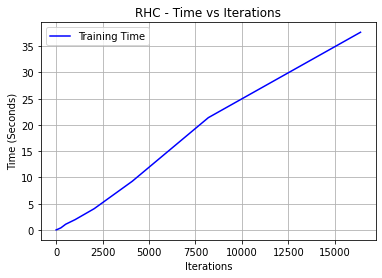

In [44]:
plt.title("RHC - Time vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Time (Seconds)") 

plt.plot(rhc["Epoch"], rhc["Train_Time"], label="Training Time", color ="blue")

plt.legend()
plt.grid()
plt.savefig('images/nn/3_sa.png')
plt.show()

### SA Algo (Simulated Annealing)

In [47]:
def run_sa(X,y, epoch_range, schedule=None):
    if not schedule:
        print("ERROR: Please provide a schedule ex:mlrose_hiive.GeomDecay()")
        return
    
    # epoch, train score, train time
    data = []
    
    for epoch in epoch_range:
        if str(type(epoch)) == str(np.int64):
            epoch = int(epoch)
        nn_model = mlrose.NeuralNetwork(
            hidden_nodes=[12, 12],
            activation='relu',
            algorithm='simulated_annealing',
            max_iters=epoch,
            bias=True,
            is_classifier=True,
            learning_rate=0.006,
            early_stopping=True,
            clip_max=1,
            max_attempts=100,
            random_state=52,
            schedule=schedule
        )
        ts = time.time()
        
        nn_model.fit(X, y)
    
        te = time.time()
        
        train_score= nn_model.score(X, y)
        
        row = [epoch, train_score, (te-ts)]
        data.append(row)
        
    df = pd.DataFrame(data, columns=['Epoch', 'Train_Score', 'Train_Time'])
    return df

In [48]:
SA_TRAINIG_RANGE = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 25000, 35000, 45000, 55000, 65000])
SA_TRAINIG_RANGE

array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
         512,  1024,  2048,  4096,  8192, 16384, 25000, 35000, 45000,
       55000, 65000])

In [49]:
# schedule = mlrose.GeomDecay(init_temp=100000, decay=0.99)
# sa_te5_d96 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [50]:
# schedule = mlrose.GeomDecay(init_temp=1000, decay=0.99)
# sa_te3_d96 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [51]:
schedule = mlrose.GeomDecay(init_temp=100000, decay=0.90)
sa_te5_d90 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [52]:
schedule = mlrose.GeomDecay(init_temp=1000, decay=0.90)
sa_te3_d90 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [53]:
# schedule = mlrose.GeomDecay(init_temp=100000, decay=0.80)
# sa_te5_d80 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [54]:
# schedule = mlrose.GeomDecay(init_temp=1000, decay=0.80)
# sa_te3_d80 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [55]:
schedule = mlrose.GeomDecay(init_temp=100000, decay=0.70)
sa_te5_d70 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [56]:
schedule = mlrose.GeomDecay(init_temp=1000, decay=0.70)
sa_te3_d70 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [57]:
# schedule = mlrose.GeomDecay(init_temp=1000, decay=0.50)
# sa_te3_d50 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

In [58]:
# schedule = mlrose.GeomDecay(init_temp=100, decay=0.99)
# sa_te1_d99 = run_sa(x_train_mm, y_train, epoch_range=SA_TRAINIG_RANGE, schedule=schedule)

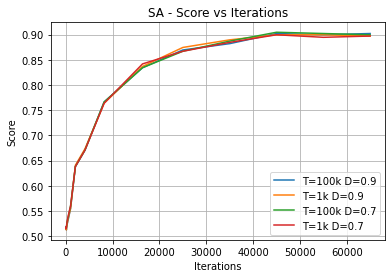

In [64]:
plt.title("SA - Score vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Score") 

# plt.plot(sa_te5_d96["Epoch"], sa_te5_d96["Train_Score"], label="sa_te5_d96")
# plt.plot(sa_te3_d96["Epoch"], sa_te3_d96["Train_Score"], label="sa_te3_d96")
plt.plot(sa_te5_d90["Epoch"], sa_te5_d90["Train_Score"], label="T=100k D=0.9")
plt.plot(sa_te3_d90["Epoch"], sa_te3_d90["Train_Score"], label="T=1k D=0.9")
# plt.plot(sa_te5_d80["Epoch"], sa_te5_d80["Train_Score"], label="sa_te5_d80")
# plt.plot(sa_te3_d80["Epoch"], sa_te3_d80["Train_Score"], label="sa_te3_d80")
plt.plot(sa_te5_d70["Epoch"], sa_te5_d70["Train_Score"], label="T=100k D=0.7")
plt.plot(sa_te3_d70["Epoch"], sa_te3_d70["Train_Score"], label="T=1k D=0.7")
# plt.plot(sa_te3_d50["Epoch"], sa_te3_d50["Train_Score"], label="sa_te3_d50")

plt.legend()
plt.grid()
plt.savefig('images/nn/sa_1.png')
plt.show()

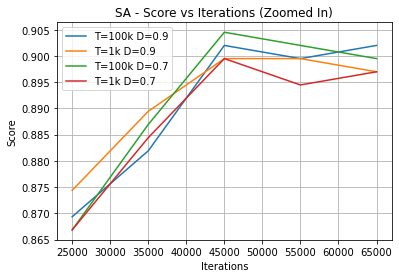

In [65]:
plt.title("SA - Score vs Iterations (Zoomed In)")
plt.xlabel("Iterations")
plt.ylabel("Score") 

b = 15
e = 25

# plt.plot(sa_te5_d96[b:e]["Epoch"], sa_te5_d96[b:e]["Train_Score"], label="sa_te5_d96")
# plt.plot(sa_te3_d96[b:e]["Epoch"], sa_te3_d96[b:e]["Train_Score"], label="sa_te3_d96")
plt.plot(sa_te5_d90[b:e]["Epoch"], sa_te5_d90[b:e]["Train_Score"], label="T=100k D=0.9")
plt.plot(sa_te3_d90[b:e]["Epoch"], sa_te3_d90[b:e]["Train_Score"], label="T=1k D=0.9")
# plt.plot(sa_te5_d80[b:e]["Epoch"], sa_te5_d80[b:e]["Train_Score"], label="sa_te5_d80")
# plt.plot(sa_te3_d80[b:e]["Epoch"], sa_te3_d80[b:e]["Train_Score"], label="sa_te3_d80")
plt.plot(sa_te5_d70[b:e]["Epoch"], sa_te5_d70[b:e]["Train_Score"], label="T=100k D=0.7")
plt.plot(sa_te3_d70[b:e]["Epoch"], sa_te3_d70[b:e]["Train_Score"], label="T=1k D=0.7")
# plt.plot(sa_te3_d50[b:e]["Epoch"], sa_te3_d50[b:e]["Train_Score"], label="sa_te3_d50")

plt.legend()
plt.grid()
plt.savefig('images/nn/sa_1_zoomed.png')
plt.show()

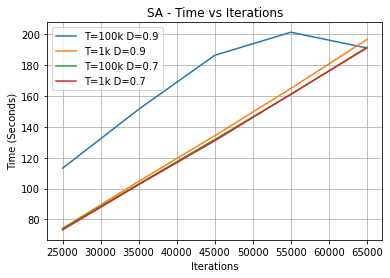

In [66]:
plt.title("SA - Time vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Time (Seconds)") 

b = 15
e = 25

# plt.plot(sa_te5_d96[b:e]["Epoch"], sa_te5_d96[b:e]["Train_Time"], label="sa_te5_d96")
# plt.plot(sa_te3_d96[b:e]["Epoch"], sa_te3_d96[b:e]["Train_Time"], label="sa_te3_d96")
plt.plot(sa_te5_d90[b:e]["Epoch"], sa_te5_d90[b:e]["Train_Time"], label="T=100k D=0.9")
plt.plot(sa_te3_d90[b:e]["Epoch"], sa_te3_d90[b:e]["Train_Time"], label="T=1k D=0.9")
# plt.plot(sa_te5_d80[b:e]["Epoch"], sa_te5_d80[b:e]["Train_Time"], label="sa_te5_d80")
# plt.plot(sa_te3_d80[b:e]["Epoch"], sa_te3_d80[b:e]["Train_Time"], label="sa_te3_d80")
plt.plot(sa_te5_d70[b:e]["Epoch"], sa_te5_d70[b:e]["Train_Time"], label="T=100k D=0.7")
plt.plot(sa_te3_d70[b:e]["Epoch"], sa_te3_d70[b:e]["Train_Time"], label="T=1k D=0.7")
# plt.plot(sa_te3_d50[b:e]["Epoch"], sa_te3_d50[b:e]["Train_Time"], label="sa_te3_d50")

plt.legend()
plt.grid()
plt.savefig('images/nn/sa_2.png')
plt.show()

In [68]:
sa_te5_d70

,Epoch,Train_Score,Train_Time
0,1,0.517588,0.024690
1,2,0.517588,0.010434
2,4,0.517588,0.012771
3,8,0.517588,0.023757
4,16,0.517588,0.048832
5,32,0.515075,0.110234
6,64,0.517588,0.195489
7,128,0.517588,0.370146
8,256,0.527638,0.726305
9,512,0.537688,1.512042


### GA Alog (Genetic)

In [71]:
def run_ga(X,y, epoch_range, pop_size=None, mutation_prob=None):
    if not pop_size:
        print("ERROR: Please provide a pop_size")
        return
    
    if not mutation_prob:
        print("ERROR: Please provide a mutation_prob")
        return
    
    # epoch, train score, train time
    data = []
    
    for epoch in epoch_range:
        if str(type(epoch)) == str(np.int64):
            epoch = int(epoch)
        
        nn_model = mlrose.NeuralNetwork(
            hidden_nodes=[12, 12],
            activation='relu',
            algorithm='genetic_alg',
            max_iters=epoch,
            bias=True,
            is_classifier=True,
            learning_rate=0.006,
            early_stopping=True,
            clip_max=1,
            max_attempts=100,
            random_state=52,
            pop_size=pop_size,
            mutation_prob=mutation_prob
        )
        ts = time.time()
        
        nn_model.fit(X, y)
    
        te = time.time()
        
        train_score= nn_model.score(X, y)
        
        row = [epoch, train_score, (te-ts)]
        data.append(row)
        
    df = pd.DataFrame(data, columns=['Epoch', 'Train_Score', 'Train_Time'])
    return df

In [72]:
# GA_TRAINIG_RANGE = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000])
GA_TRAINIG_RANGE = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
GA_TRAINIG_RANGE

array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])

In [73]:
pop_size = 10
mutation_prob = 0.1

ga_p10_m10 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [74]:
pop_size = 20
mutation_prob = 0.25

ga_p20_m25 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [75]:
# pop_size = 20
# mutation_prob = 0.5

# ga_p20_m50 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [76]:
# pop_size = 50
# mutation_prob = 0.1

# ga_p50_m10 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [77]:
pop_size = 50
mutation_prob = 0.25

ga_p50_m25 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [78]:
pop_size = 50
mutation_prob = 0.5

ga_p50_m50 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [79]:
# pop_size = 50
# mutation_prob = 0.75

# ga_p50_m75 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [80]:
# pop_size = 100
# mutation_prob = 0.1

# ga_p100_m10 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [81]:
# pop_size = 100
# mutation_prob = 0.25

# ga_p100_m25 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [82]:
pop_size = 100
mutation_prob = 0.5

ga_p100_m50 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

In [83]:
# pop_size = 100
# mutation_prob = 0.75

# ga_p100_m75 = run_ga(x_train_mm, y_train, epoch_range=GA_TRAINIG_RANGE, pop_size=pop_size, mutation_prob=mutation_prob)

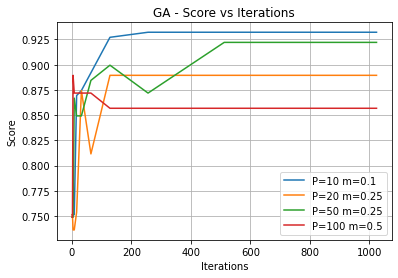

In [95]:
plt.title("GA - Score vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Score") 

b=0
e=11

plt.plot(ga_p10_m10[b:e]["Epoch"], ga_p10_m10[b:e]["Train_Score"], label="P=10 m=0.1")
plt.plot(ga_p20_m25[b:e]["Epoch"], ga_p20_m25[b:e]["Train_Score"], label="P=20 m=0.25")
# plt.plot(ga_p20_m50[b:e]["Epoch"], ga_p20_m50[b:e]["Train_Score"], label="pop=20 m=50")

# plt.plot(ga_p50_m10[b:e]["Epoch"], ga_p50_m10[b:e]["Train_Score"], label="pop=50 m=10")
plt.plot(ga_p50_m25[b:e]["Epoch"], ga_p50_m25[b:e]["Train_Score"], label="P=50 m=0.25")
# plt.plot(ga_p50_m50[b:e]["Epoch"], ga_p50_m50[b:e]["Train_Score"], label="P=50 m=50")
# plt.plot(ga_p50_m75[b:e]["Epoch"], ga_p50_m75[b:e]["Train_Score"], label="pop=50 m=75")

plt.plot(ga_p100_m50[b:e]["Epoch"], ga_p50_m50[b:e]["Train_Score"], label="P=100 m=0.5")

plt.legend()
plt.grid()
plt.savefig('images/nn/ga_1.png')
plt.show()

In [86]:
ga_p10_m10

,Epoch,Train_Score,Train_Time
0,1,0.751256,0.063266
1,2,0.751256,0.058437
2,4,0.751256,0.067200
3,8,0.751256,0.143971
4,16,0.869347,0.389971
5,32,0.874372,0.705783
6,64,0.891960,1.175155
7,128,0.927136,2.243573
8,256,0.932161,4.634460
9,512,0.932161,4.965805


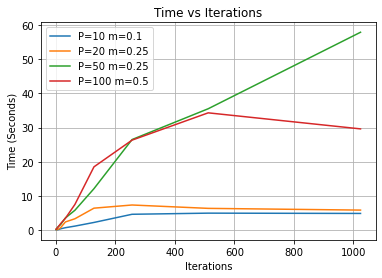

In [96]:
plt.title("Time vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Time (Seconds)") 

b=0
e=11

plt.plot(ga_p10_m10[b:e]["Epoch"], ga_p10_m10[b:e]["Train_Time"], label="P=10 m=0.1")
plt.plot(ga_p20_m25[b:e]["Epoch"], ga_p20_m25[b:e]["Train_Time"], label="P=20 m=0.25")
plt.plot(ga_p50_m25[b:e]["Epoch"], ga_p50_m25[b:e]["Train_Time"], label="P=50 m=0.25")
plt.plot(ga_p100_m50[b:e]["Epoch"], ga_p50_m50[b:e]["Train_Time"], label="P=100 m=0.5")

plt.legend()
plt.grid()
plt.savefig('images/nn/ga_2.png')
plt.show()

# Comparison


Algo | Score | Time| Iterations
--- | --- | --- | ---
Gradient Descent | 0.942211 | 0.934598| 256
RHC | 0.939698 | 37.665653| 16384
SA | 0.904523 | 131.791398| 45000
GA | 0.932161 | 4.634460| 256


In [ ]:
# - Gradient Descent: score=0.942211, time=0.934598,   iterations=256
# - RHC:              score=0.939698, time=37.665653,  iterations=16384
# - SA:               score=0.904523, time=131.791398, iterations=45000
# - GA:               score=0.932161, time=4.634460,   iterations=256


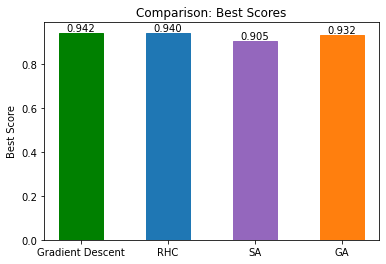

In [123]:
x_labels = ["Gradient Descent", "RHC", "SA", "GA"]
y_values = [0.942211, 0.939698, 0.904523, 0.932161]

plt.title("Comparison: Best Scores")
plt.ylabel("Best Score") 

bars = plt.bar(x_labels, y_values, width=0.5)

bars[0].set_color('green')
bars[1].set_color('tab:blue')
bars[2].set_color('tab:purple')
bars[3].set_color('tab:orange')

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, ("%.3f" % height), ha='center', va='bottom')


plt.savefig('images/nn/best_scores.png')
plt.show()

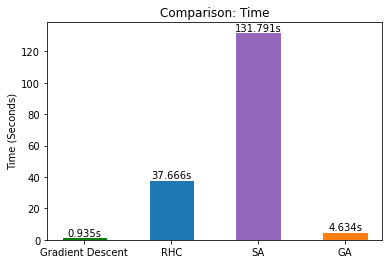

In [124]:
x_labels = ["Gradient Descent", "RHC", "SA", "GA"]
y_values = [0.934598, 37.665653, 131.791398, 4.634460]

plt.title("Comparison: Time")
plt.ylabel("Time (Seconds)") 

bars = plt.bar(x_labels, y_values, width=0.5)

bars[0].set_color('green')
bars[1].set_color('tab:blue')
bars[2].set_color('tab:purple')
bars[3].set_color('tab:orange')

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, ("%.3f" % height) + "s", ha='center', va='bottom')

plt.savefig('images/nn/best_times.png')
plt.show()